In [1]:
import pandas as pd
import os
import seaborn as sns
import warnings

from plotting_tools import *

# Update rcParams to set the default font to Times New Roman
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [2]:
# define experiment to be preprocessed
experiment_series = "2025_02_18"

resolution = "3_min_resolution" 
rain_scenario = "KeinRegen" 
degradation_setting = "no_decay" 

In [3]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

In [4]:
def get_crosscorr_for_one_station(df_combined, sampling_location, lags_in_hours):
    df_combined_sub = df_combined.loc[df_combined.sampling_point==sampling_location, :].sort_values("hours")
    return [crosscorr(df_combined_sub["COVID_copies/l"], df_combined_sub["I_total"], lag) for lag in lags_in_hours]

In [23]:
parameter_setting = "tauE_minus_20"

In [24]:
df_wastewater = pd.read_csv(os.path.join("../..", "preprocessing/preprocessed_data/wastewater_model", experiment_series, "concentrations", f"{resolution}_{rain_scenario}_{degradation_setting}_{parameter_setting}.csv"))
df_wastewater.sampling_point = df_wastewater.sampling_point.map({"MW022": "1", "MW023": "2", "MW017": "3", "MW043": "4", "MW048": "5", "RW157": "6", "MW046": "7", "MW061": "8", 
                                                                 "RW143": "9", "RW141": "10", "RW155": "11", "MW059": "12", "RW211": "13", "MW054": "14", "RW126": "15", "MW052": "16"})
df_wastewater = df_wastewater.loc[df_wastewater.minutes>0,:]
df_wastewater["hours"] = df_wastewater["minutes"]/60
df_wastewater = df_wastewater[[int(x)==x for x in df_wastewater.hours]] # only subselect full hours

In [25]:
infection_model_simulation_path = os.path.join("../../simulation_output/infection_model", experiment_series, parameter_setting)

def tidy_console_output(memilio_output_path, memilio_id):
    df = pd.read_csv(os.path.join(memilio_output_path, f"{memilio_id}_console_output.csv"), sep=" ", index_col=False)
    df["memilio_id"] = memilio_id
    df = df[["t", "memilio_id", "S","E","Ins","Isy","Isev","Icri","R","D"]]
    df.columns = ["time", "memilio_id", "S", "E", "I_ns", "I_sy", "I_sev", "I_cri", "R", "D"]
    df["I_total"] = df["E"] + df["I_ns"] + df["I_sy"] + df["I_sev"] + df["I_cri"] 
    return df

df_prevalence = [tidy_console_output(infection_model_simulation_path, memilio_id) for memilio_id in range(1, 251)]
df_prevalence = pd.concat(df_prevalence)

In [26]:
warnings.filterwarnings("ignore", message="An input array is constant; the correlation coefficient is not defined.")
warnings.filterwarnings("ignore", message="invalid value encountered in divide")

max_lag = 45
results = []
sampling_location = 16
    
loc_corr = []
for sim in df_prevalence['memilio_id'].unique():
    curr_sim_ww = df_wastewater.loc[df_wastewater['memilio_id'] == sim]
    curr_sim_prev = df_prevalence.loc[df_prevalence['memilio_id'] == sim]
    curr_combined = curr_sim_ww.merge(curr_sim_prev, left_on="hours", right_on="time", how="left")
    loc_corr.append(get_crosscorr_for_one_station(curr_combined, str(sampling_location), range(-max_lag, max_lag+1, 1)))
    
df_corr = pd.DataFrame(loc_corr)
results.append(df_corr.mean(axis = 0))
    
df_res = pd.DataFrame(results).transpose()
df_res.columns = ['16']
df_res["lag_in_h"] = range(-max_lag, max_lag+1, 1)
df_res = df_res.set_index("lag_in_h")

In [27]:
df_res.max().to_frame().T.round(2)

,16
0,0.55


In [28]:
df_res.idxmax().to_frame().T

,16
0,-28


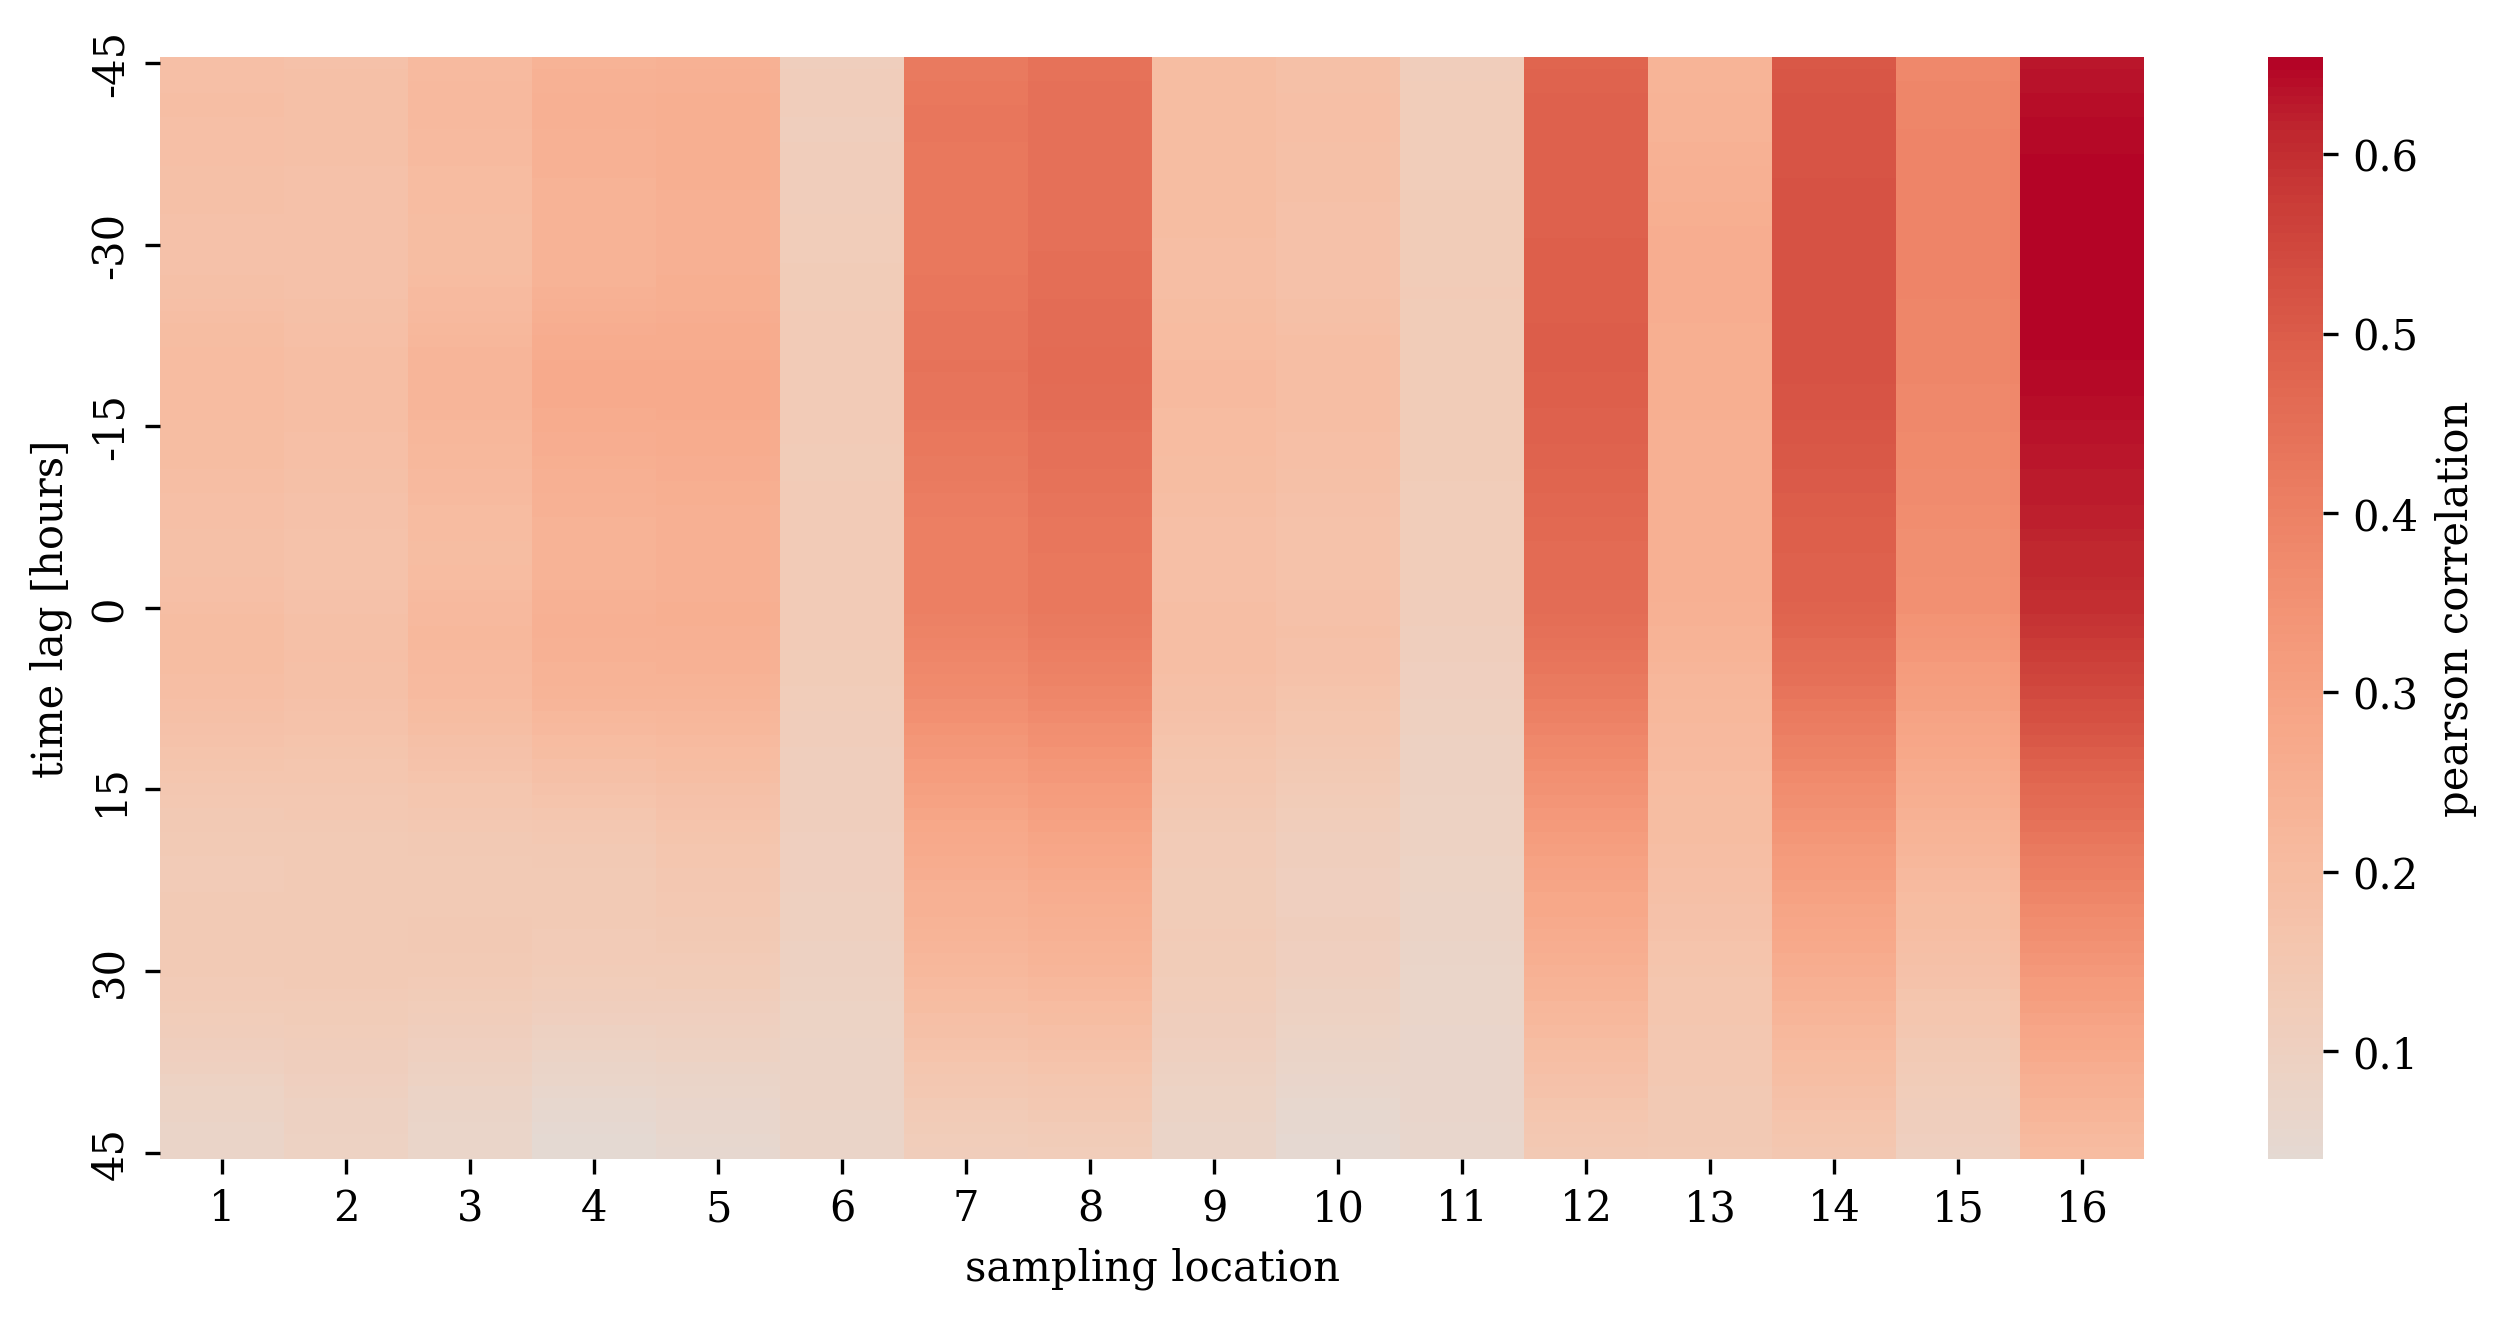

In [33]:
fig, ax = plt.subplots(figsize = (9,4.5), dpi=300) 
lb = sns.heatmap(df_res[[str(i) for i in range(1,17)]], cmap='coolwarm', center=0, yticklabels=15, cbar_kws={'label': 'pearson correlation'})
ax.set_xlabel("sampling location")
ax.set_ylabel("time lag [hours]")

plt.tight_layout()
# fig.savefig(f"test.png", dpi=300)